In [2]:
import warnings
warnings.filterwarnings("ignore")

# Choropleth Mapping



## Principles


Choropleths are geographic maps that display statistical information encoded 
in a colour palette. Choropleth maps play a prominent role in geographic data science as they allow
us to display non-geographic attributes or variables on a geographic map. The
word choropleth stems from the root "choro", meaning "region". As such
choropleth maps represent data at the region level, and are appropriate for
areal unit data where each observation combines a value of an attribute and a
geometric figure, usually a polygon. Choropleth maps derive from an earlier era
where cartographers faced technological constraints that precluded the use of
unclassed maps where each unique attribute value could be represented by a
distinct symbol or colour. Instead, attribute values were grouped into a smaller
number of classes, usually not more than 12. Each class was associated with a
unique symbol that was in turn applied to all observations with attribute values
falling in the class.

Although today these technological constraints are no longer binding, and
unclassed mapping is feasible, there are still good reasons for adopting a
classed approach. Chief among these is to reduce the cognitive load involved in
parsing the complexity of an unclassed map. A choropleth map reduces this
complexity by drawing upon statistical and visualization theory to provide an
effective representation of the spatial distribution of the attribute values
across the areal units. 

The effectiveness of a choropleth map depends largely on the purpose of the map.
Which message you want to communicate will shape what options are preferable
over others. In this chapter we consider three dimensions over which putting
intentional thinking will pay off. Choropleth mapping thus revolves around: first,
selecting a number of groups smaller than $n$ into which all values in our dataset 
will be mapped to; second, identifying a classification algorithm that executes such
mapping, following some principle that is aligned with our interest; and third, once
we know into how many groups we are going to reduce all values in our data, which
colour is assigned to each group to ensure it encodes the information we want to reflect.
In broad terms, the classification scheme
defines the number of classes as well as the rules for assignment; while a good
symbolization conveys information about the value differentiation across
classes.

In this chapter we first discuss the approaches used to classify attribute
values. This is followed by a (brief) overview of colour theory and the implications of
different colour schemes for effective map design. We combine theory and practice
by exploring how these concepts are implemented in different Python packages,
including `geopandas`, and `PySAL`.




In [3]:
import seaborn
import pandas
import geopandas
import pysal
import numpy
import matplotlib.pyplot as plt

## Quantitative data classification 

Selecting the number of groups into which we want to assign the values in our data,
and how each value is assigned into a group can be seen as a classification problem.
Data classification considers the problem of 
partitioning the attribute values into mutually exclusive and exhaustive
groups. The precise manner in which this is done will be a function of the
measurement scale of the attribute in question. For quantitative attributes
(ordinal, interval, ratio scales) the classes will have an explicit ordering.
More formally, the classification problem is to define class boundaries such
that

$$
c_j < y_i \le  c_{j+1} \ \forall y_i \in C_{j}
$$

where $y_i$ is the
value of the attribute for spatial location $i$, $j$ is a class index, and $c_j$
represents the lower bound of interval $j$. Different classification schemes obtain from their definition of the class
boundaries. The choice of the classification scheme should take into
consideration the statistical distribution of the attribute values as well
as the goal of our map (e.g., highlight outliers Vs accurately depict the distribution of values).

To illustrate these considerations, we will examine regional income data for the
32 Mexican states used in the paper by {cite}`Rey_2010`. The variable we focus on is per capita gross domestic product
for 1940 (`PCGDP1940`):

In [4]:
mx = geopandas.read_file("data/mexico/mexicojoin.shp")
mx[['NAME', 'PCGDP1940']].head()

,NAME,PCGDP1940
0,Baja California Norte,22361.0
1,Baja California Sur,9573.0
2,Nayarit,4836.0
3,Jalisco,5309.0
4,Aguascalientes,10384.0


Which displays the following statistical distribution:

In [5]:
mx['PCGDP1940'].describe()

count       32.000000
mean      7230.531250
std       5204.952883
min       1892.000000
25%       3701.750000
50%       5256.000000
75%       8701.750000
max      22361.000000
Name: PCGDP1940, dtype: float64

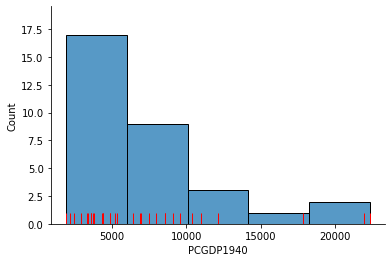

In [6]:
# Plot histogram
ax = seaborn.histplot(mx['PCGDP1940'], bins=5)
# Add rug on horizontal axis
seaborn.rugplot(
    mx['PCGDP1940'], height=0.05, color='red', ax=ax
);

As we can see, the distribution is positively skewed as in common in regional income studies. In other words,
the mean exceeds the median (`50%`, in the table below), leading the to fat right tail in the figure. As
we shall see, this skewness will have implications for the choice of choropleth
classification scheme.

For quantitative attributes we first sort the data by their value,
such that $x_0 \le x_2 \ldots \le x_{n-1}$. For a prespecified number of classes
$k$, the classification problem boils down to selecting $k-1$ break points
along the sorted values that separate the values into mutually exclusive and
exhaustive groups.

In fact, the determination of the histogram above can
be viewed as one approach to this selection.
The method `seaborn.histplot` uses the matplotlib `hist`
function under the hood to determine the class boundaries and the counts of
observations in each class. In the figure, we have five classes which can be
extracted with an explicit call to the `hist` function:

In [7]:
counts, bins, patches = ax.hist(mx['PCGDP1940'], bins=5)

The `counts` object captures how many observations each category in the classification has:

In [8]:
counts

array([17.,  9.,  3.,  1.,  2.])

The `bin` object stores these break points we are interested in when considering classification schemes (the `patches` object can be ignored in this context, as it stores the geometries of the histogram plot):

In [9]:
bins

array([ 1892. ,  5985.8, 10079.6, 14173.4, 18267.2, 22361. ])

This yields five bins, with the first having a lower bound of 1892 and an upper
bound of 5985.8 which contains 17 observations. The determination of the
interval width ($w$) and the number of bins in `seaborn` is based on the Freedman-Diaconis rule {cite}`freedman1981histogram`:

$$
w = 2 * IQR * n^{-1/3}
$$

where $IQR$ is the inter quartile
range of the attribute values. Given $w$, the number of bins ($k$) is:

$$k = \dfrac{(max-min)}{w}$$

The choropleth literature has many alternative classification algorithms that follow criteria that can be of interest in different contexts, as they focus on different priorities. Below, we will focus on a few of them. To compute the classification, we will rely on the `mapclassify` package of the PySAL family:

In [10]:
import mapclassify

### Equal Intervals

The Freedman-Diaconis approach provides a rule to determine the width and, in
turn, the number of bins for the classification. This is a special case of a
more general classifier known as "equal intervals", where each of the bins has
the same width in the value space. For a given value of $k$, equal intervals
classification splits the range of the attribute space into $k$ equal length
intervals, with each interval having a width $w = \frac{x_0 - x_{n-1}}{k}$. Thus
the maximum class is $(x_{n-1}-w, x_{n-1}]$ and the first class is $(-\infty,
x_{n-1} - (k-1)w]$.

Equal intervals have the dual advantages of simplicity and ease of
interpretation. However, this rule only considers the extreme values of the
distribution and, in some cases, this can result in one or more classes being
sparse. This is clearly the case in our income dataset, as the majority of the
values are placed into the first two classes leaving the last three classes
rather sparse:

In [11]:
ei5 = mapclassify.EqualInterval(mx['PCGDP1940'], k=5)
ei5

EqualInterval               

      Interval         Count
----------------------------
[ 1892.00,  5985.80] |    17
( 5985.80, 10079.60] |     9
(10079.60, 14173.40] |     3
(14173.40, 18267.20] |     1
(18267.20, 22361.00] |     2

 Note that each of the intervals, however, has equal width of
$w=4093.8$. It should also be noted that the first class is closed on the lower bound,
in contrast to the general approach defined above.

### Quantiles
To avoid the potential problem of sparse classes, the quantiles of
the distribution can be used to identify the class boundaries. Indeed, each
class will have approximately $\mid\frac{n}{k}\mid$ observations using the quantile
classifier. If $k=5$ the sample quintiles are used to define the upper limits of
each class resulting in the following classification:

In [12]:
q5 = mapclassify.Quantiles(mx.PCGDP1940, k=5)
q5

Quantiles                   

      Interval         Count
----------------------------
[ 1892.00,  3576.20] |     7
( 3576.20,  4582.80] |     6
( 4582.80,  6925.20] |     6
( 6925.20,  9473.00] |     6
( 9473.00, 22361.00] |     7

Note that while the numbers of values in each class are roughly equal, the
widths of the first four intervals are rather different:

In [13]:
q5.bins[1:] - q5.bins[:-1]

array([ 1006.6,  2342.4,  2547.8, 12888. ])

### Mean-standard deviation

Our third classifier uses the sample mean $\bar{x} =
\frac{1}{n} \sum_{i=1}^n x_i$ and sample standard deviation $s = \sqrt{
\frac{1}{n-1} \sum_{i=1}^n (x_i - \bar{x})  }$ to define class boundaries as
some distance from the sample mean, with the distance being a multiple of the
standard deviation. For example, a common definition for $k=5$ is to set the
upper limit of the first class to two standard deviations ($c_{0}^u = \bar{x} - 2 s$), and the intermediate
classes to have upper limits within one standard deviation ($c_{1}^u = \bar{x}-s,\ c_{2}^u = \bar{x}+s, \ c_{3}^u
= \bar{x}+2s$). Any values greater (smaller) than two standard deviations above (below) the mean
are placed into the top (bottom) class.

In [14]:
msd = mapclassify.StdMean(mx['PCGDP1940'])
msd

StdMean                     

      Interval         Count
----------------------------
(    -inf, -3179.37] |     0
(-3179.37,  2025.58] |     1
( 2025.58, 12435.48] |    28
(12435.48, 17640.44] |     0
(17640.44, 22361.00] |     3

This classifier is best used when data is normally distributed or, 
at least, when the sample mean is a meaningful measure to anchor the classification around. Clearly this is
not the case for our income data as the positive skew results in a loss of
information when we use the standard deviation. The lack of symmetry leads to
an inadmissible upper bound for the first  class as well as a concentration of the
vast majority of values in the middle class.

### Maximum Breaks

The maximum breaks classifier decides where to set the break points between
classes by considering the difference between sorted values. That is, rather
than considering a value of the dataset in itself, it looks at how apart each
value is from the next one in the sorted sequence. The classifier then places
the $k-1$ break points in between the pairs of values most stretched apart from
each other in the entire sequence, proceeding in descending order relative to
the size of the breaks:

In [15]:
mb5 = mapclassify.MaximumBreaks(mx['PCGDP1940'], k=5)
mb5

MaximumBreaks               

      Interval         Count
----------------------------
[ 1892.00,  5854.00] |    17
( 5854.00, 11574.00] |    11
(11574.00, 14974.00] |     1
(14974.00, 19890.50] |     1
(19890.50, 22361.00] |     2

Maximum breaks is an appropriate approach when we are interested in making sure
observations in each class are separated from those in neighboring classes. As
such, it works well in cases where the distribution of values is not unimodal.
In addition, the algorithm is relatively fast to compute. However, its
simplicity can sometimes cause unexpected results. To the extent in only
considers the top $k-1$ differences between consecutive values, other more nuanced
within-group differences and dissimilarities can be ignored.

### Head-Tail Breaks

The head tail algorithm {cite}`Jiang_2013` is based on a recursive partitioning of the data using splits around
iterative means. The splitting process continues until the distributions within each of
the classes no longer display a heavy-tailed distribution in the sense that
there is a balance between the number of smaller and larger values assigned to
each class.

In [16]:
ht = mapclassify.HeadTailBreaks(mx['PCGDP1940'])
ht

HeadTailBreaks              

      Interval         Count
----------------------------
[ 1892.00,  7230.53] |    20
( 7230.53, 12244.42] |     9
(12244.42, 20714.00] |     1
(20714.00, 22163.00] |     1
(22163.00, 22361.00] |     1

For data with a heavy-tailed distribution, such as power law and log normal
distributions, the head tail breaks classifier  can be particularly
effective.

### Jenks Caspall

This approach, as well as the following two, tackles the classification
challenge from a heuristic perspective, rather than from deterministic one.
Originally proposed by {cite}`Jenks_1971`, this algorithm aims to minimise
the sum of absolute deviations around class means. The approach begins with a
prespecified number of classes and an arbitrary initial set of class breaks -
for example using quintiles. The algorithm attempts to improve the objective
function by considering the movement of observations between adjacent classes.
For example, the largest value in the lowest quintile would be considered for
movement into the second quintile, while the lowest value in the second
quintile would be considered for a possible move into the first quintile. The
candidate move resulting in the largest reduction in the objective function
would be made, and the process continues until no other improving moves are
possible. The Jenks Caspall algorithm is the one-dimension case of the widely
used K-Means algorithm for clustering.

In [17]:
numpy.random.seed(12345)
jc5 = mapclassify.JenksCaspall(mx['PCGDP1940'], k=5)
jc5

JenksCaspall                

      Interval         Count
----------------------------
[ 1892.00,  2934.00] |     4
( 2934.00,  4414.00] |     9
( 4414.00,  6399.00] |     5
( 6399.00, 12132.00] |    11
(12132.00, 22361.00] |     3

### Fisher Jenks

The second optimal algorithm adopts a dynamic programming approach to minimise
the sum of the absolute deviations around class medians. In contrast to the
Jenks-Caspall approach, Fisher-Jenks is guaranteed to produce an optimal
classification for a prespecified number of classes:

In [18]:
numpy.random.seed(12345)
fj5 = mapclassify.FisherJenks(mx['PCGDP1940'], k=5)
fj5

FisherJenks                 

      Interval         Count
----------------------------
[ 1892.00,  5309.00] |    17
( 5309.00,  9073.00] |     8
( 9073.00, 12132.00] |     4
(12132.00, 17816.00] |     1
(17816.00, 22361.00] |     2

### Max-p

Finally, the max-p classifiers adopts the algorithm underlying the max-p region
building method {cite}`Duque_2011` to the case of map classification. It is similar in spirit to
Jenks Caspall in that it considers greedy swapping between adjacent classes to
improve the objective function. It is a heuristic, however, so unlike
Fisher-Jenks, there is no optimal solution guaranteed:

In [19]:
mp5 = mapclassify.MaxP(mx['PCGDP1940'], k=5)
mp5

MaxP                        

      Interval         Count
----------------------------
[ 1892.00,  3569.00] |     7
( 3569.00,  5309.00] |    10
( 5309.00,  7990.00] |     5
( 7990.00, 10384.00] |     5
(10384.00, 22361.00] |     5

### Comparing Classification schemes

As a special case of clustering, the definition of
the number of classes and the class boundaries pose a problem to the map
designer. Recall that the Freedman-Diaconis rule was said to be optimal,
however, the optimality necessitates the specification of an objective function.
In the case of Freedman-Diaconis, the objective function is to minimise the
difference between the area under estimated kernel density based on the sample
and the area under the theoretical population distribution that generated the
sample. 

This notion of statistical fit is an important one. However, it is not the
only consideration when evaluating classifiers for the purpose of choropleth
mapping. Also relevant is the spatial distribution of the attribute values and
the ability of the classifier to convey a sense of that spatial distribution. As
we shall see, this is not necessarily directly related to the statistical
distribution of the attribute values. We will return to a joint consideration of both
the statistical and spatial distribution of the attribute values in comparison
of classifiers below.

For map classification, a common optimality criterion
is a measure of fit. In PySAL, the "absolute deviation around class
medians" (ADCM) is calculated and provides a measure of fit that allows for
comparison of alternative classifiers for the same value of $k$. The ADCM
will give us a sense of how "compact" each group is. To see this, we can
compare different classifiers for $k=5$ on the Mexico data:

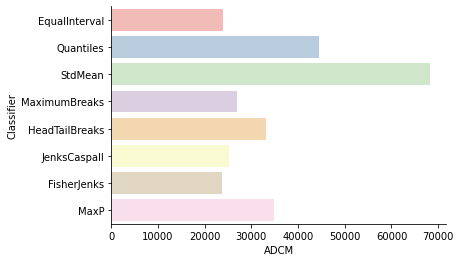

In [20]:
# Bunch classifier objects
class5 = ei5, q5, msd, mb5, ht, jc5, fj5, mp5
# Collect ADCM for each classifier
fits = numpy.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pandas.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']
ax = seaborn.barplot(
    y='Classifier', x='ADCM', data=adcms, palette='Pastel1'
)

As is to be expected, the Fisher-Jenks classifier dominates all other k=5
classifiers with an ADCM of 23,729 (remember, lower is better). Interestingly, the equal interval classifier
performs well despite the problems associated with being sensitive to the
extreme values in the distribution. The mean-standard deviation classifier has a
very poor fit due to the skewed nature of the data and the concentrated
assignment of the majority of the observations to the central class.

## Colour

Having considered the evaluation of the statistical distribution of
the attribute values and the alternative classification approaches, we turn
to select the symbolisation and colour scheme. Together with the choice 
of classifier, these will determine the overall
effectiveness of the choropleth map in representing the spatial
distribution of the attribute values.

Prior to examining the attribute values it is important to note that, as we will
see in the figures below, the
spatial units for these states are far from homogeneous in their shapes and
sizes. This can have major impacts on our brain's pattern recognition capabilities
as we tend to be drawn to the larger polygons, even though they might not be
the most relevant one for our analysis. Yet, when we considered the
statistical distribution above, each observation was given equal weight. Thus,
the spatial distribution becomes more complicated to evaluate from a visual and
statistical perspective.

The choice of a colour scheme for a
choropleth map should be based on the type of variable under consideration
{cite}`Brewer1997mapping`. For example, the data may be sequential, diverging, and qualitative.

We will illustrate it with a quantile map:

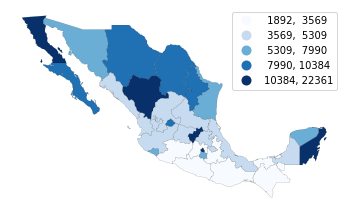

In [24]:
ax = mx.plot(
    column='PCGDP1940',          # Data to plot
    scheme='MaxP',          # Classification scheme
    cmap='Blues',                 # Colour palette
    edgecolor='k',               # Borderline colour
    linewidth=0.1,               # Borderline width
    legend=True,                 # Add legend
    legend_kwds={'fmt':'{:.0f}'} # Remove decimals in legend
)
ax.set_axis_off();

Making choropleths on geo-tables is an extension of plotting their geometries. We use the same `.plot` function but now we also select the column of data we want to encode with colour (in our case, `PCGDP1940`). We can also specify the classification scheme using the same names as we saw above with `mapclassify`. In fact, the underlying computation is always performed with `mapclassify`. This approach simply dispatches it so it is more convenient and we can make maps in one line of code.
Next, we pick the colour scheme. The default colour map used by `geopandas` is viridis, which is a multi-hue sequential scheme but, for this example, we pick the blues scale from Colour Brewer. A list of different colour mappings can be found here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
Finally, we specify we would like to add a legend, and format it for legibility so that there are no decimals and it reads cleaner.

### Diverging Palettes

A slightly different pallete from the sequential one is the so-called "diverging" values palette. This is
useful with continuous data when one wishes to place equal emphasis on mid-range critical values as
well as extremes at both ends of the distribution. Light colours are used to
emphasize the mid-range class while dark colours with contrasting hues are used
to distinguish the low and high extremes.

To illustrate this with the Mexican
income data, we can derive a new variable which measures the change in a state's
rank in the income distribution between 1940 to 2000:

In [26]:
# Create income-based rank table (Rank 1 is highest)
rnk = mx[
    ['NAME', 'PCGDP1940', 'PCGDP2000']
].rank(ascending=False)
# Compute change from 1940 to 2000
rnk['change'] = rnk['PCGDP1940'] - rnk['PCGDP2000']
# Add column with bin class
rnk['class'] = pandas.cut(rnk['change'], [-numpy.inf, -5, 0, 5, 20])

The `rnk` table now contains the change in rank positions of each state between 1940 and 2000, as well as a `class` column that binds together states in the  [-inf, -5), [-5, 0), [0, 5), [5, 20] groups. Note that these are descending ranks, so the wealthiest state in any period has a rank of 1 and therefore when considering the change in ranks, a negative change reflects moving down the income distribution. We can use a divergent palette to signify both intensity of the change in ranks, as well as direction:

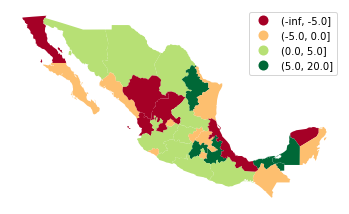

In [27]:
ax = mx[['geometry']].join(rnk).plot(
    'class', legend=True, cmap='RdYlGn'
)
ax.set_axis_off();

In the map, the red (green) hues are states that have moved downwards (upwards) in the
income distribution, with the darker hue representing a larger movement.